## Libraries

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
model=load_model("./Model/model")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_245 (Conv2D)          (None, 100, 100, 100)     200       
_________________________________________________________________
activation_368 (Activation)  (None, 100, 100, 100)     0         
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 50, 50, 100)       0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 49, 49, 80)        32080     
_________________________________________________________________
activation_369 (Activation)  (None, 49, 49, 80)        0         
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 24, 24, 80)        0         
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 22, 22, 64)        46144     
__________

In [29]:
path="./Data/2/img22.jpeg"

img=plt.imread(path)
img=cv2.resize(img,(100,100))
try:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
except:
    img=img

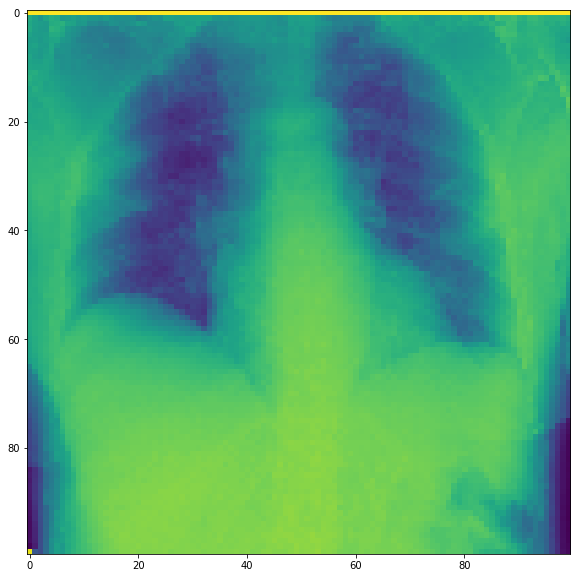

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [6]:
np.argmax(model.predict(img.reshape(-1,100,100,1)))

0

In [7]:
model.layers

In [80]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output])
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)
            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]
        
        
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)


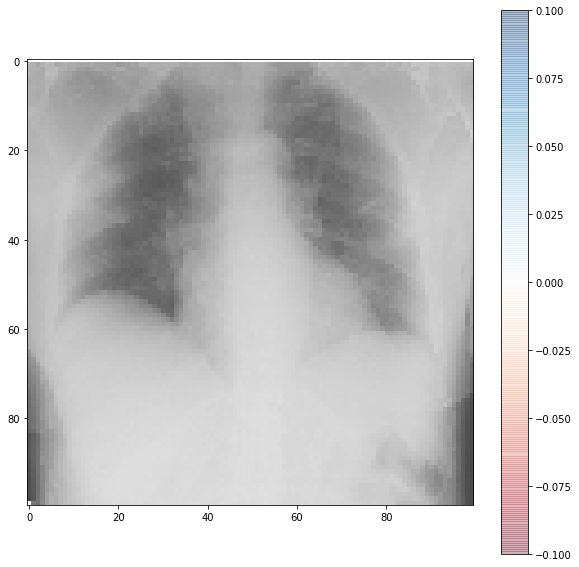

In [71]:
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='RdBu', alpha=0.3)
plt.colorbar()

In [ ]:
gradModel = Model(inputs=[model.input],outputs=[model.get_layer('conv2d_250').output,model.output])

In [97]:
def predictImage(model, image):
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:,np.argmax(predictions)]

    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    heatmap = cv2.resize(cam.numpy(), (100, 100))
    heatmap=cv2.resize(heatmap,(100,100))
    return [predictions.numpy(),heatmap]

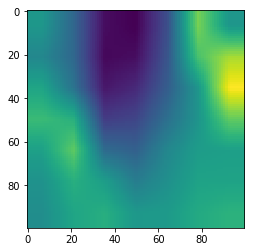

In [98]:
plt.imshow(predictImage(gradModel,image)[1])

In [99]:
predictImage(gradModel,image)[0]

array([[2.1785633e-26, 1.0571295e-15, 1.0000000e+00]], dtype=float32)

In [104]:
class GradMapModel:
    def __init__(self,model):
        self.model=model
    
    def predict(self,image):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = self.model(inputs)
            loss = predictions[:,np.argmax(predictions)]

        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        return [predictions.numpy(),cam.numpy()]

In [105]:
GMModel = GradMapModel(Model(inputs=[model.input],outputs=[model.get_layer('conv2d_250').output,model.output]))

In [106]:
GMModel.predict(image)

[array([[2.1785633e-26, 1.0571295e-15, 1.0000000e+00]], dtype=float32),
 array([[1.0137320e-15, 7.5400062e-16, 3.6120651e-16, 3.1543592e-16,
         6.3204106e-16, 1.3678718e-15, 1.0062768e-15],
        [9.2741701e-16, 7.5842817e-16, 3.4249719e-16, 3.6279594e-16,
         6.6202359e-16, 1.2545007e-15, 1.4605393e-15],
        [1.0902425e-15, 8.1886211e-16, 3.9970659e-16, 4.7030710e-16,
         7.0543551e-16, 1.0050210e-15, 1.6362938e-15],
        [1.2126920e-15, 1.1512581e-15, 5.4988807e-16, 5.9036656e-16,
         8.0096944e-16, 9.9889092e-16, 1.3173741e-15],
        [1.0643467e-15, 1.3087102e-15, 7.7880709e-16, 7.2360796e-16,
         9.2695464e-16, 1.0435293e-15, 1.0575439e-15],
        [9.8723321e-16, 1.1443741e-15, 1.0500809e-15, 8.7141468e-16,
         9.7567777e-16, 1.0755956e-15, 1.0777484e-15],
        [9.6468551e-16, 1.0911885e-15, 1.1419513e-15, 1.0184891e-15,
         1.0315565e-15, 1.1165855e-15, 1.1607137e-15]], dtype=float32)]

In [109]:
GMM=Model(inputs=[model.input],outputs=[model.get_layer('conv2d_250').output,model.output])

In [110]:
GMM.save("./Model/GMM")